In [ ]:
## CHIRAG VERMA
## E22CSEU0875
import json

file = "All_Beauty.jsonl"

def process_jsonl_file(file_path):
    """Processes a JSONL file and yields valid JSON objects."""
    with open(file_path, 'r') as fp:
        buffer = ''  # Buffer to accumulate partial JSON objects
        for line in fp:
            buffer += line.strip()  # Add current line to buffer
            try:
                # Attempt to parse the buffer as JSON
                data = json.loads(buffer)
                yield data  # Yield the parsed JSON object
                buffer = ''  # Reset the buffer for the next object
            except json.JSONDecodeError:
                # If parsing fails, it's likely an incomplete object
                # Continue to the next line to accumulate more data
                continue

# Iterate through the valid JSON objects in the file
for data in process_jsonl_file(file):
    print(data)

Streaming output truncated to the last 5000 lines.
{'rating': 1.0, 'title': 'Dispose after one use. Very thin and small.', 'text': 'These are very small and very thin. Yes they are disposable but most disposables can be used more than once. Not these.', 'images': [], 'asin': 'B0834YSK51', 'parent_asin': 'B0834YSK51', 'user_id': 'AHRHYCHEBCXOA5KMQHO3FTXE2E2Q', 'timestamp': 1608949312814, 'helpful_vote': 0, 'verified_purchase': True}
{'rating': 5.0, 'title': 'CHerry good.', 'text': 'CHerry good.', 'images': [], 'asin': 'B01ETEAS72', 'parent_asin': 'B01ETEAS72', 'user_id': 'AHRHYCHEBCXOA5KMQHO3FTXE2E2Q', 'timestamp': 1486247790000, 'helpful_vote': 2, 'verified_purchase': True}
{'rating': 5.0, 'title': 'DO IT', 'text': '[[VIDEOID:68d89655d2ba05c912bd1fc4e9d72109]] Bright color, Awesome scent, Super nice and healthy looking hair! Love the teal ♡', 'images': [], 'asin': 'B07RM6XVKS', 'parent_asin': 'B07RM6XVKS', 'user_id': 'AF44QBQIWSPO556YZOJH34NGFWEQ', 'timestamp': 1623453769265, 'helpful_

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.classification import GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("Amazon Reviews Sentiment Analysis - LR").getOrCreate()

print("Spark Session Initialized!")


Spark Session Initialized!


In [3]:
# File path
file_path = "All_Beauty.jsonl"

# Load JSONL data into a Spark DataFrame
df = spark.read.json(file_path)

# Show the schema to verify the structure
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



In [4]:
# Count the total number of records
total_records = df.count()

print(f"Total number of records: {total_records}")

Total number of records: 53258


In [5]:
# Display the first few rows
df.show(truncate=False)

+----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Create Sentiment Column
from pyspark.sql.functions import col, when, lit
df = df.withColumn("sentiment", when(col("rating") >= 4, lit(1)).otherwise(lit(0)))

# Select Relevant Columns
df = df.select("text", "sentiment", "verified_purchase").na.drop()

# Show Processed Data
df.show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+
|text                                                                                                                                                                                                                                                                                                        |sentiment|verified_purchase|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+
|This s

In [7]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

# Tokenize Text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

# Pipeline for Preprocessing
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf])
processed_df = pipeline.fit(df).transform(df)

# Show Processed Features
processed_df.select("features", "sentiment").show(5)


+--------------------+---------+
|            features|sentiment|
+--------------------+---------+
|(10000,[322,488,3...|        1|
|(10000,[153,264,4...|        1|
|(10000,[322,3934,...|        1|
|(10000,[2658,9673...|        0|
|(10000,[6240],[1....|        1|
+--------------------+---------+
only showing top 5 rows



In [8]:
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)

In [9]:
## Training And Evaluation

def train_and_evaluate(model, train_df, test_df, model_name):
    # Fit the model
    model = model.fit(train_df)

    # Make predictions
    predictions = model.transform(test_df)

    # Evaluate metrics
    evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    # auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    evaluator_roc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc_score = evaluator_roc.evaluate(predictions)


    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)

    print(f"{model_name}: Accuracy = {accuracy:.4f}")
    print(f"{model_name}: Precision = {precision:.4f}")
    print(f"{model_name}: Recall = {recall:.4f}")
    print(f"{model_name}:  F1-Score = {f1_score:.4f}")
    print(f"{model_name}: AUC = {auc_score}")

    return model
    return predictions


In [10]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
# Train Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="sentiment", maxIter=20, regParam=0.1)
lr_model = train_and_evaluate(lr, train_df, test_df, "Logistic Regression")

# Predictions
lr_predictions = lr_model.transform(test_df)

# Assuming 'dt_predictions' DataFrame has 'sentiment' (true labels) and 'prediction' (predicted labels) columns
reg_evaluator = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")
rmse = reg_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE):", rmse)
mae = reg_evaluator.evaluate(lr_predictions,  {reg_evaluator.metricName: "mae"})
print("Mean Absolute Error (MAE):", mae)
mse = reg_evaluator.evaluate(lr_predictions,  {reg_evaluator.metricName: "mse"})
print("Mean Squared Error (MSE):", mse)
r2 = reg_evaluator.evaluate(lr_predictions,  {reg_evaluator.metricName: "r2"})
print("R-squared (R2):", r2)

Logistic Regression: Accuracy = 0.8201
Logistic Regression: Precision = 0.8174
Logistic Regression: Recall = 0.8201
Logistic Regression:  F1-Score = 0.7979
Logistic Regression: AUC = 0.873299646667673
Root Mean Squared Error (RMSE): 0.42411622511515557
Mean Absolute Error (MAE): 0.1798745724059293
Mean Squared Error (MSE): 0.1798745724059293
R-squared (R2): 0.06304489625568954


In [12]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol="sentiment", featuresCol="features", maxDepth=5)
dt_model = train_and_evaluate(dt, train_df, test_df, "Decision Tree")  # Get the model, not predictions

# Make predictions using the model
dt_predictions = dt_model.transform(test_df)  # Get predictions DataFrame

# Assuming 'dt_predictions' DataFrame has 'sentiment' (true labels) and 'prediction' (predicted labels) columns
reg_evaluator = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="rmse")  # Keep original metricName

# Calculate RMSE
rmse = reg_evaluator.evaluate(dt_predictions)  # Pass the predictions DataFrame
print(f"Decision Tree RMSE: {rmse:.4f}")
mae = reg_evaluator.evaluate(dt_predictions, {reg_evaluator.metricName: "mae"})  # Pass the predictions DataFrame
print(f"Decision Tree MAE: {mae:.4f}")
mse = reg_evaluator.evaluate(dt_predictions, {reg_evaluator.metricName: "mse"})  # Pass the predictions DataFrame
print(f"Decision Tree MSE: {mse:.4f}")
r2 = reg_evaluator.evaluate(dt_predictions, {reg_evaluator.metricName: "r2"})  # Pass the predictions DataFrame
print(f"Decision Tree R2: {r2:.4f}")

Decision Tree: Accuracy = 0.7495
Decision Tree: Precision = 0.7461
Decision Tree: Recall = 0.7495
Decision Tree:  F1-Score = 0.6583
Decision Tree: AUC = 0.39178625442382636
Decision Tree RMSE: 0.5005
Decision Tree MAE: 0.2505
Decision Tree MSE: 0.2505
Decision Tree R2: -0.3047


In [13]:
# Train a basic Naive Bayes model
nb = NaiveBayes(labelCol="sentiment", featuresCol="features", smoothing=1.0)
nb_model = train_and_evaluate(nb, train_df, test_df, "Naive Bayes")  # Get the model, not predictions

# Generate predictions on the test set
nb_predictions = nb_model.transform(test_df)

# Convert predictions into numeric values for regression metrics
# Since NaiveBayesClassifier outputs probabilities, use prediction column as numeric.
nb_predictions = nb_predictions.withColumn("prediction_numeric", nb_predictions["prediction"].cast("double"))

# Evaluate RMSE, MSE, MAE, and R-squared
evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="r2")

nb_rmse = evaluator_rmse.evaluate(nb_predictions)
nb_mse = evaluator_mse.evaluate(nb_predictions)
nb_mae = evaluator_mae.evaluate(nb_predictions)
nb_r2 = evaluator_r2.evaluate(nb_predictions)

print(f"  Naive Bayes RMSE: {nb_rmse:.4f}")
print(f"  Naive Bayes MSE:  {nb_mse:.4f}")
print(f"  Naive Bayes MAE:  {nb_mae:.4f}")
print(f"  Naive Bayes R2:   {nb_r2:.4f}")

Naive Bayes: Accuracy = 0.8057
Naive Bayes: Precision = 0.8158
Naive Bayes: Recall = 0.8057
Naive Bayes:  F1-Score = 0.8096
Naive Bayes: AUC = 0.5392864988692021
  Naive Bayes RMSE: 0.4408
  Naive Bayes MSE:  0.1943
  Naive Bayes MAE:  0.1943
  Naive Bayes R2:   -0.0122


In [14]:
# Train a basic Random Forest model
rf = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=20, maxDepth=5)
rf_model = train_and_evaluate(rf, train_df, test_df, "Random Forest")  # Get the model, not predictions

# Generate predictions on the test set
rf_predictions = rf_model.transform(test_df)

# Convert predictions into numeric values for regression metrics
rf_predictions = rf_predictions.withColumn("prediction_numeric", rf_predictions["prediction"].cast("double"))

# Evaluate RMSE, MSE, MAE, and R-squared
evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="r2")

rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mse = evaluator_mse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)
print()
print(f" Random Forest RMSE: {rf_rmse:.4f}")
print(f" Random Forest MSE:  {rf_mse:.4f}")
print(f" Random Forest MAE:  {rf_mae:.4f}")
print(f" Random Forest R2:   {rf_r2:.4f}")


Random Forest: Accuracy = 0.7409
Random Forest: Precision = 0.5489
Random Forest: Recall = 0.7409
Random Forest:  F1-Score = 0.6306
Random Forest: AUC = 0.7231717614068285

 Random Forest RMSE: 0.5090
 Random Forest MSE:  0.2591
 Random Forest MAE:  0.2591
 Random Forest R2:   -0.3497


In [15]:
from pyspark.ml.classification import GBTClassifier

# Train a basic Gradient Boosted Tree (GBT) model
gbt = GBTClassifier(labelCol="sentiment", featuresCol="features", maxIter=10, maxDepth=5)
gbt_model = train_and_evaluate(gbt, train_df, test_df, "Gradient Boosted Tree")  # Get the model, not predictions

# Generate predictions on the test set
gbt_predictions = gbt_model.transform(test_df)

# Convert predictions into numeric values for regression metrics
gbt_predictions = gbt_predictions.withColumn("prediction_numeric", gbt_predictions["prediction"].cast("double"))

# Evaluate RMSE, MSE, MAE, and R-squared
evaluator_rmse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="sentiment", predictionCol="prediction_numeric", metricName="r2")

gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_mse = evaluator_mse.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)
print()

print(f" Gradient Boosted Tree RMSE: {gbt_rmse:.4f}")
print(f" Gradient Boosted Tree MSE:  {gbt_mse:.4f}")
print(f" Gradient Boosted Tree MAE:  {gbt_mae:.4f}")
print(f" Gradient Boosted Tree R2:   {gbt_r2:.4f}")


Gradient Boosted Tree: Accuracy = 0.7658
Gradient Boosted Tree: Precision = 0.7828
Gradient Boosted Tree: Recall = 0.7658
Gradient Boosted Tree:  F1-Score = 0.6930
Gradient Boosted Tree: AUC = 0.7665739020569584

 Gradient Boosted Tree RMSE: 0.4840
 Gradient Boosted Tree MSE:  0.2342
 Gradient Boosted Tree MAE:  0.2342
 Gradient Boosted Tree R2:   -0.2201


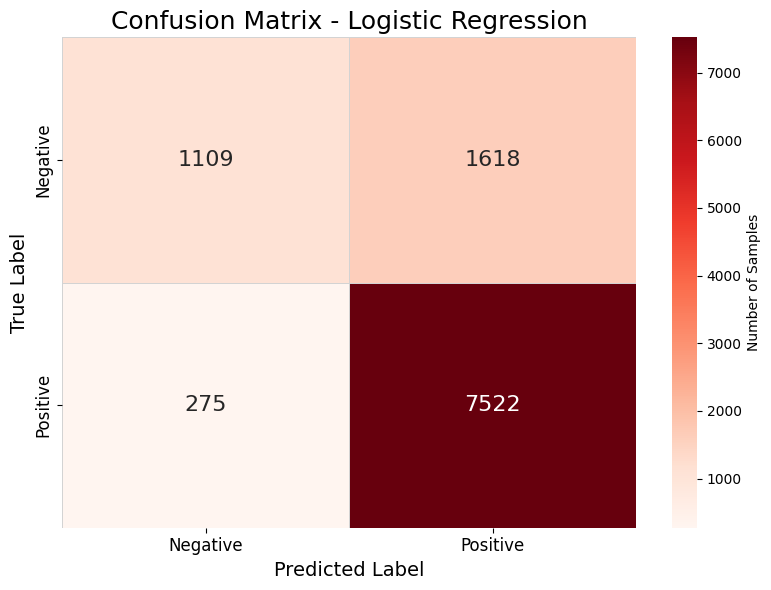

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Predictions and Labels
# Replace these with the actual predictions and labels from your Spark DataFrame
y_true = lr_predictions.select("sentiment").toPandas()["sentiment"]
y_pred = lr_predictions.select("prediction").toPandas()["prediction"]

# Compute Confusion Matrix
cm_lr = confusion_matrix(y_true, y_pred)

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            annot_kws={"size": 16}, # Increase font size of annotations
            linewidths=.5, # Add lines between cells
            linecolor='lightgray', # Set line color
            cbar_kws={'label': 'Number of Samples'}) # Add colorbar label
plt.title("Confusion Matrix - Logistic Regression", fontsize=18) # Increase title font size
plt.xlabel("Predicted Label", fontsize=14) # Increase x-axis label font size
plt.ylabel("True Label", fontsize=14) # Increase y-axis label font size
plt.xticks(fontsize=12) # Increase x-axis tick font size
plt.yticks(fontsize=12) # Increase y-axis tick font size
plt.tight_layout()
plt.show()

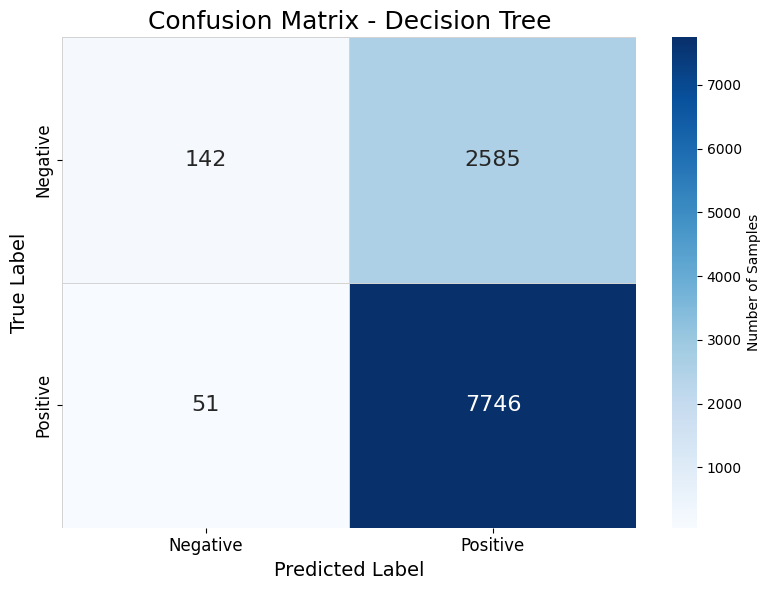

In [17]:
# Example: Predictions and Labels
# Replace these with the actual predictions and labels from your Spark DataFrame
y_true_dt = dt_predictions.select("sentiment").toPandas()["sentiment"]
y_pred_dt = dt_predictions.select("prediction").toPandas()["prediction"]

# Compute Confusion Matrix
cm_dt = confusion_matrix(y_true_dt, y_pred_dt)

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            annot_kws={"size": 16}, # Increase font size of annotations
            linewidths=.5, # Add lines between cells
            linecolor='lightgray', # Set line color
            cbar_kws={'label': 'Number of Samples'}) # Add colorbar label
plt.title("Confusion Matrix - Decision Tree", fontsize=18) # Increase title font size
plt.xlabel("Predicted Label", fontsize=14) # Increase x-axis label font size
plt.ylabel("True Label", fontsize=14) # Increase y-axis label font size
plt.xticks(fontsize=12) # Increase x-axis tick font size
plt.yticks(fontsize=12) # Increase y-axis tick font size
plt.tight_layout()
plt.show()

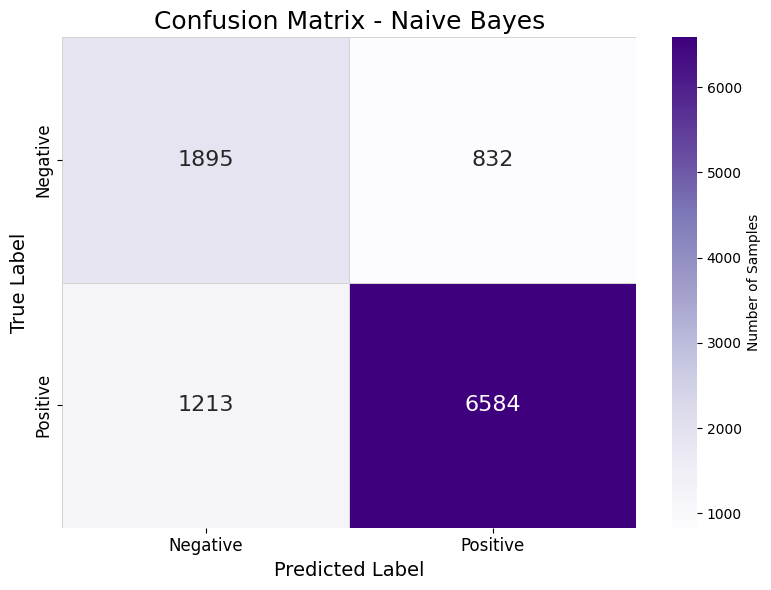

In [18]:
# Example: Predictions and Labels
# Replace these with the actual predictions and labels from your Spark DataFrame
y_true_nb = nb_predictions.select("sentiment").toPandas()["sentiment"]
y_pred_nb = nb_predictions.select("prediction").toPandas()["prediction"]

# Compute Confusion Matrix
cm_nb = confusion_matrix(y_true_nb, y_pred_nb)

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            annot_kws={"size": 16}, # Increase font size of annotations
            linewidths=.5, # Add lines between cells
            linecolor='lightgray', # Set line color
            cbar_kws={'label': 'Number of Samples'}) # Add colorbar label
plt.title("Confusion Matrix - Naive Bayes", fontsize=18) # Increase title font size
plt.xlabel("Predicted Label", fontsize=14) # Increase x-axis label font size
plt.ylabel("True Label", fontsize=14) # Increase y-axis label font size
plt.xticks(fontsize=12) # Increase x-axis tick font size
plt.yticks(fontsize=12) # Increase y-axis tick font size
plt.tight_layout()
plt.show()

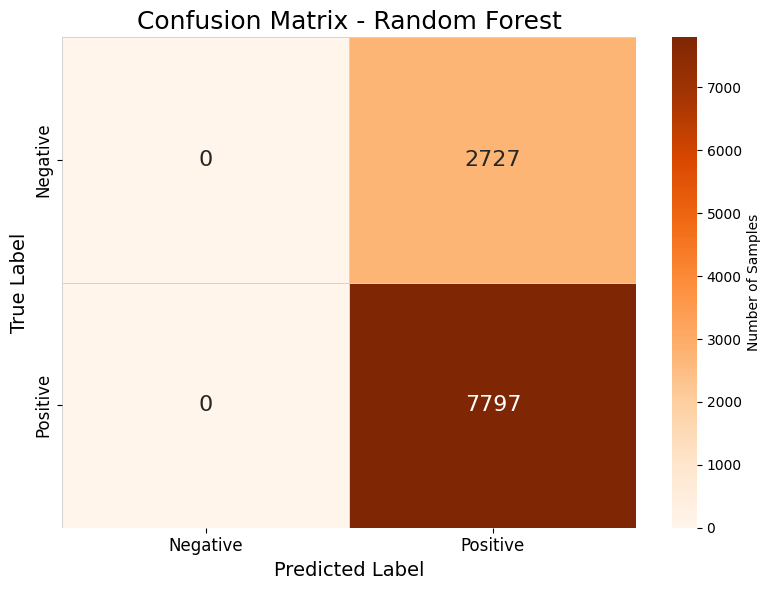

In [19]:
# Example: Predictions and Labels
# Replace these with the actual predictions and labels from your Spark DataFrame
y_true_rf = rf_predictions.select("sentiment").toPandas()["sentiment"]
y_pred_rf = rf_predictions.select("prediction").toPandas()["prediction"]

# Compute Confusion Matrix
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            annot_kws={"size": 16}, # Increase font size of annotations
            linewidths=.5, # Add lines between cells
            linecolor='lightgray', # Set line color
            cbar_kws={'label': 'Number of Samples'}) # Add colorbar label
plt.title("Confusion Matrix - Random Forest", fontsize=18) # Increase title font size
plt.xlabel("Predicted Label", fontsize=14) # Increase x-axis label font size
plt.ylabel("True Label", fontsize=14) # Increase y-axis label font size
plt.xticks(fontsize=12) # Increase x-axis tick font size
plt.yticks(fontsize=12) # Increase y-axis tick font size
plt.tight_layout()
plt.show()

In [20]:
# Example: Predictions and Labels
# Replace these with the actual predictions and labels from your Spark DataFrame
y_true_gbt = gbt_predictions.select("sentiment").toPandas()["sentiment"]
y_pred_gbt = gbt_predictions.select("prediction").toPandas()["prediction"]

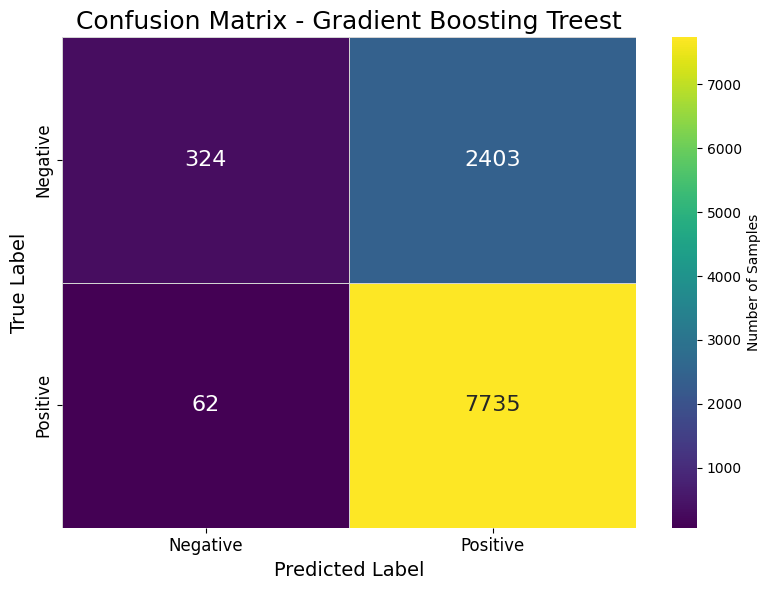

In [24]:
# Compute Confusion Matrix
cm_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbt, annot=True, fmt="d", cmap="viridis",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            annot_kws={"size": 16}, # Increase font size of annotations
            linewidths=.5, # Add lines between cells
            linecolor='lightgray', # Set line color
            cbar_kws={'label': 'Number of Samples'}) # Add colorbar label
plt.title("Confusion Matrix - Gradient Boosting Treest", fontsize=18) # Increase title font size
plt.xlabel("Predicted Label", fontsize=14) # Increase x-axis label font size
plt.ylabel("True Label", fontsize=14) # Increase y-axis label font size
plt.xticks(fontsize=12) # Increase x-axis tick font size
plt.yticks(fontsize=12) # Increase y-axis tick font size
plt.tight_layout()
plt.show()

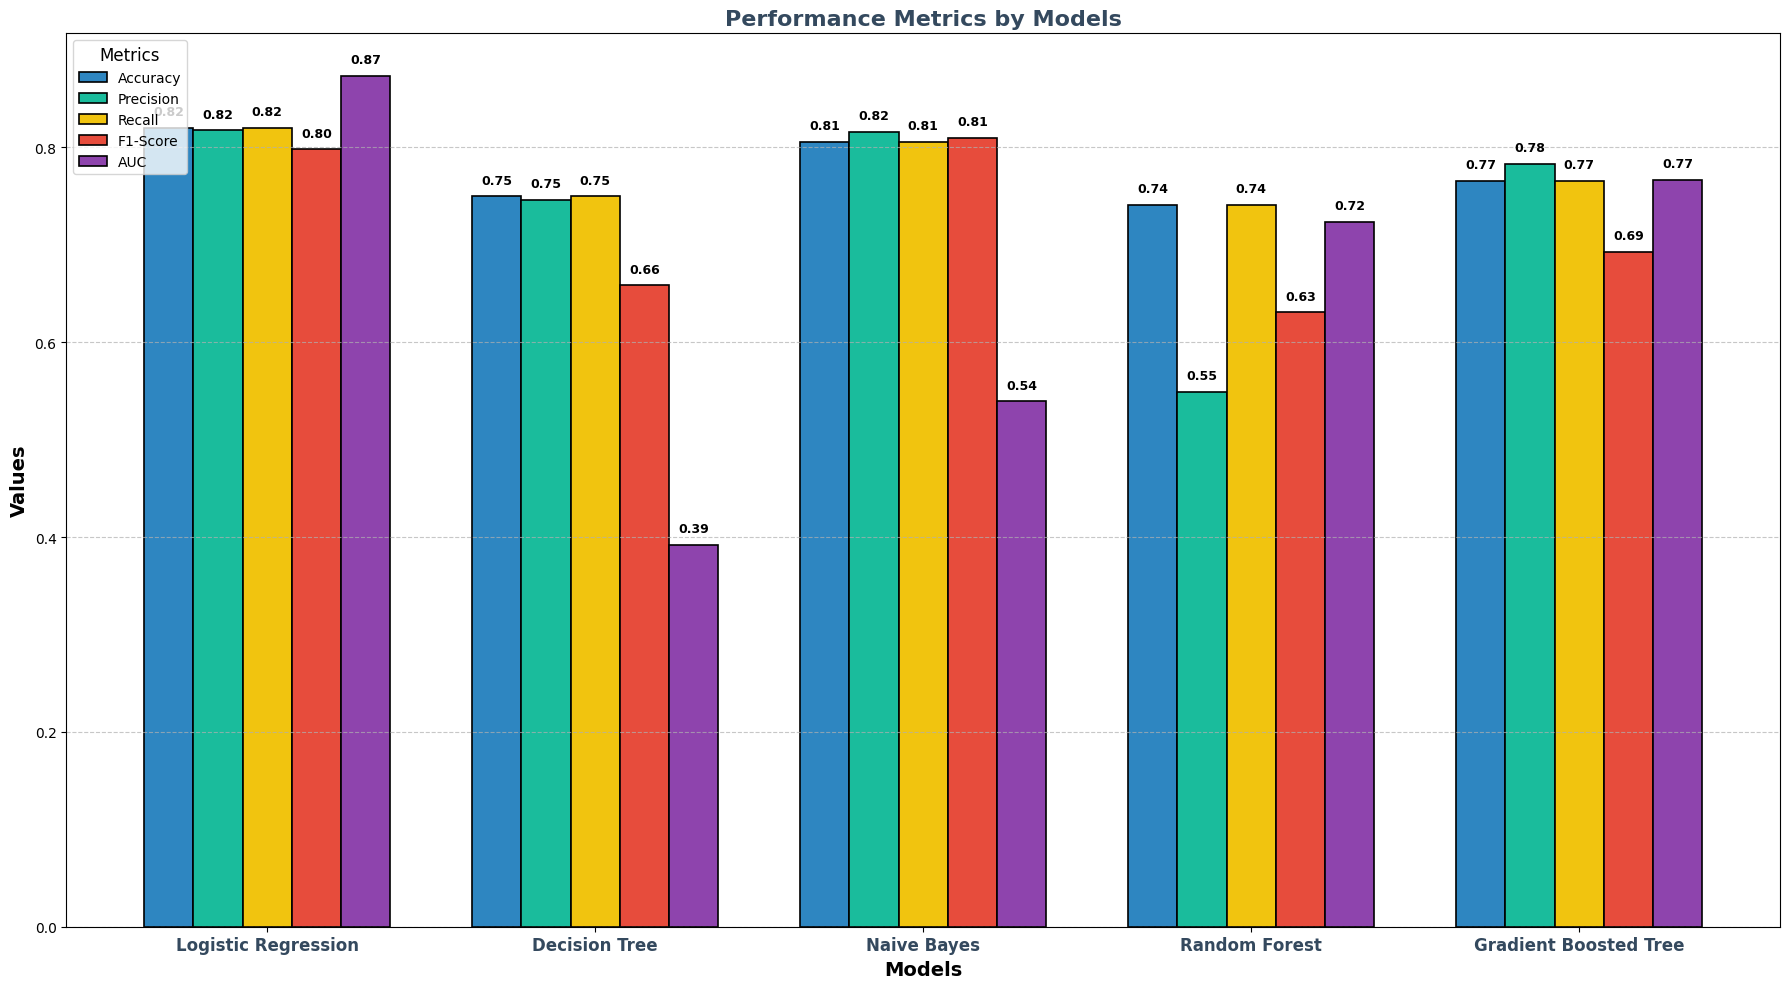

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for models and their performance metrics
models = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'Gradient Boosted Tree']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [
    [0.8201, 0.8174, 0.8201, 0.7979, 0.8733],  # Logistic Regression
    [0.7495, 0.7461, 0.7495, 0.6583, 0.3918],  # Decision Tree
    [0.8057, 0.8158, 0.8057, 0.8096, 0.5393],  # Naive Bayes
    [0.7409, 0.5489, 0.7409, 0.6306, 0.7232],  # Random Forest
    [0.7658, 0.7828, 0.7658, 0.6930, 0.7666]   # Gradient Boosted Tree
]

# Transpose the values so metrics become grouped by models on x-axis
values_transposed = list(zip(*values))

# Bar width and positions
bar_width = 0.15
x = np.arange(len(models))

# Set up the plot
fig, ax = plt.subplots(figsize=(18, 10))
colors = ['#2E86C1', '#1ABC9C', '#F1C40F', '#E74C3C', '#8E44AD']

# Plotting each metric's values grouped by models
for i, (metric, metric_values) in enumerate(zip(metrics, values_transposed)):
    ax.bar(x + i * bar_width, metric_values, bar_width, label=metric, color=colors[i], edgecolor='black', linewidth=1.2)

# Customizing the plot
ax.set_title("Performance Metrics by Models", fontsize=16, fontweight='bold', color="#34495E")
ax.set_xlabel("Models", fontsize=14, fontweight='bold')
ax.set_ylabel("Values", fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models, fontsize=12, fontweight='bold', color="#34495E")
ax.legend(title="Metrics", fontsize=10, title_fontsize=12, loc="upper left")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data values on bars
for i, metric_values in enumerate(values_transposed):
    for j, value in enumerate(metric_values):
        ax.text(x[j] + i * bar_width, value + 0.01, f"{value:.2f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

# Adjusting layout
plt.tight_layout()
plt.show()


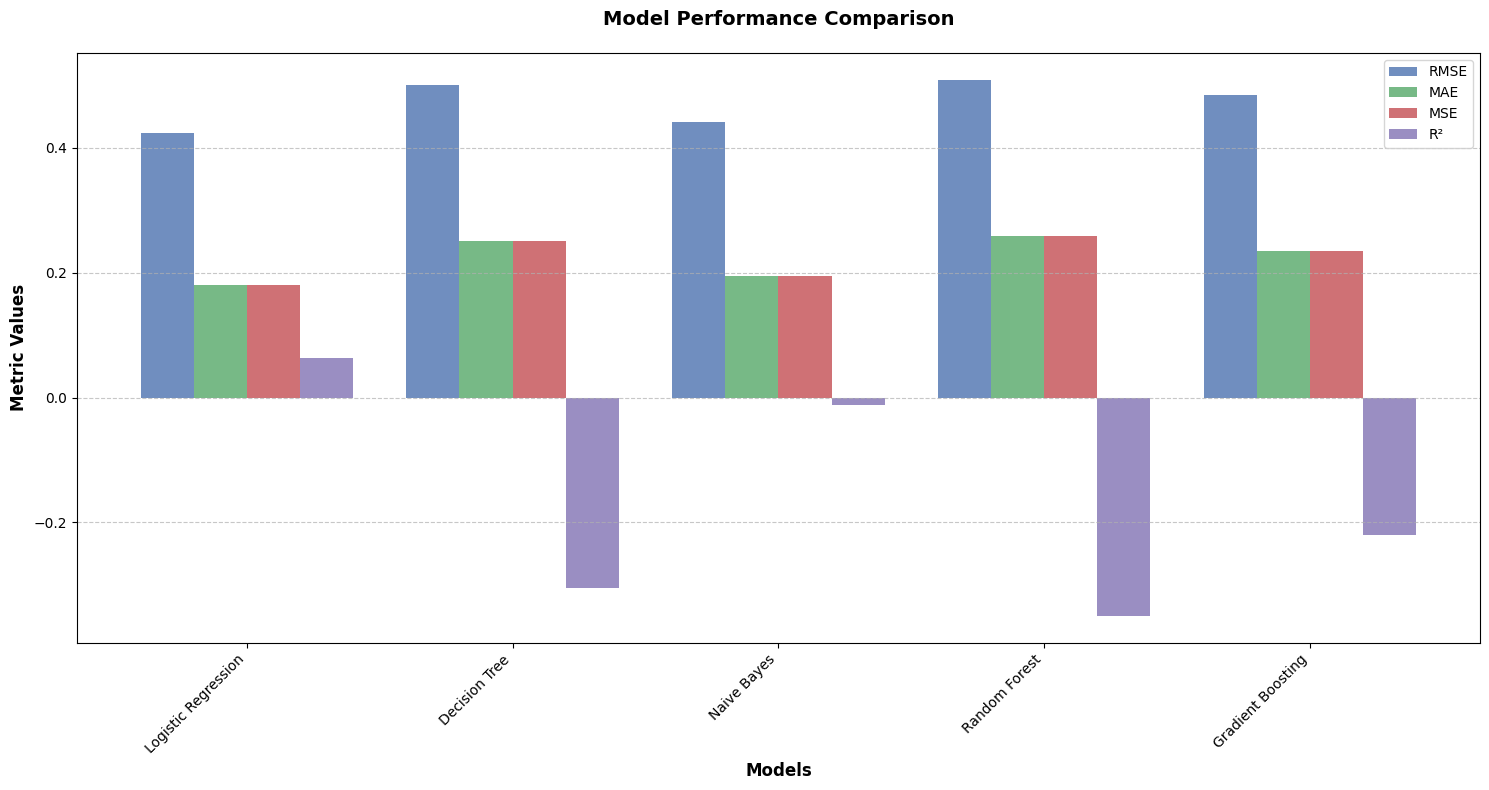

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the model metrics
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [0.4241, 0.5005, 0.4408, 0.5090, 0.4840],
    'MAE': [0.1799, 0.2505, 0.1943, 0.2591, 0.2342],
    'MSE': [0.1799, 0.2505, 0.1943, 0.2591, 0.2342],
    'R2': [0.0630, -0.3047, -0.0122, -0.3497, -0.2201]
}

df = pd.DataFrame(data)

# Set the style and figure size
# plt.style.use('seaborn')
plt.figure(figsize=(15, 8))

# Create the bar plot
x = np.arange(len(df['Model']))
width = 0.2

plt.bar(x - width*1.5, df['RMSE'], width, label='RMSE', color='#4C72B0', alpha=0.8)
plt.bar(x - width/2, df['MAE'], width, label='MAE', color='#55A868', alpha=0.8)
plt.bar(x + width/2, df['MSE'], width, label='MSE', color='#C44E52', alpha=0.8)
plt.bar(x + width*1.5, df['R2'], width, label='R²', color='#8172B3', alpha=0.8)

# Customize the plot
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Metric Values', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x, df['Model'], rotation=45, ha='right')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [34]:
## HYPERPARAMETER TUNING

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [35]:
def tune_and_train_with_metrics(model, param_grid, train_df, test_df, model_name):
    # Set up evaluator for accuracy
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="f1")

    # Set up CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator_accuracy,  # Primary evaluator for tuning
                              numFolds=3,  # Use 3-fold cross-validation
                              parallelism=2)  # Speed up with parallelism

    # Train model with CrossValidator
    cv_model = crossval.fit(train_df)

    # Get best model
    best_model = cv_model.bestModel

    # Evaluate on test data
    predictions = best_model.transform(test_df)
    accuracy = evaluator_accuracy.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)

    print(f"{model_name}:")
    print(f"  - Accuracy  = {accuracy:.4f}")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}")
    print(f"  - F1-Score  = {f1_score:.4f}\n")

    return best_model, predictions, accuracy, precision, recall, f1_score

In [36]:
# prompt: Generate Logistic regression model with hyperparameter tuning, also add precision, recall, f1 score and auc

from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Assuming train_df and test_df are already defined

# Logistic Regression with Hyperparameter Tuning
lr = LogisticRegression(labelCol="sentiment", featuresCol="features")

# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Perform hyperparameter tuning and train
lr_model, lr_predictions, lr_accuracy, lr_precision, lr_recall, lr_f1_score = tune_and_train_with_metrics(
    lr, param_grid, train_df, test_df, "Logistic Regression"
)


# Evaluate AUC
evaluator_auc = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {auc:.4f}")


Logistic Regression:
  - Accuracy  = 0.8294
  - Precision = 0.8221
  - Recall    = 0.8294
  - F1-Score  = 0.8234

Logistic Regression AUC: 0.8513


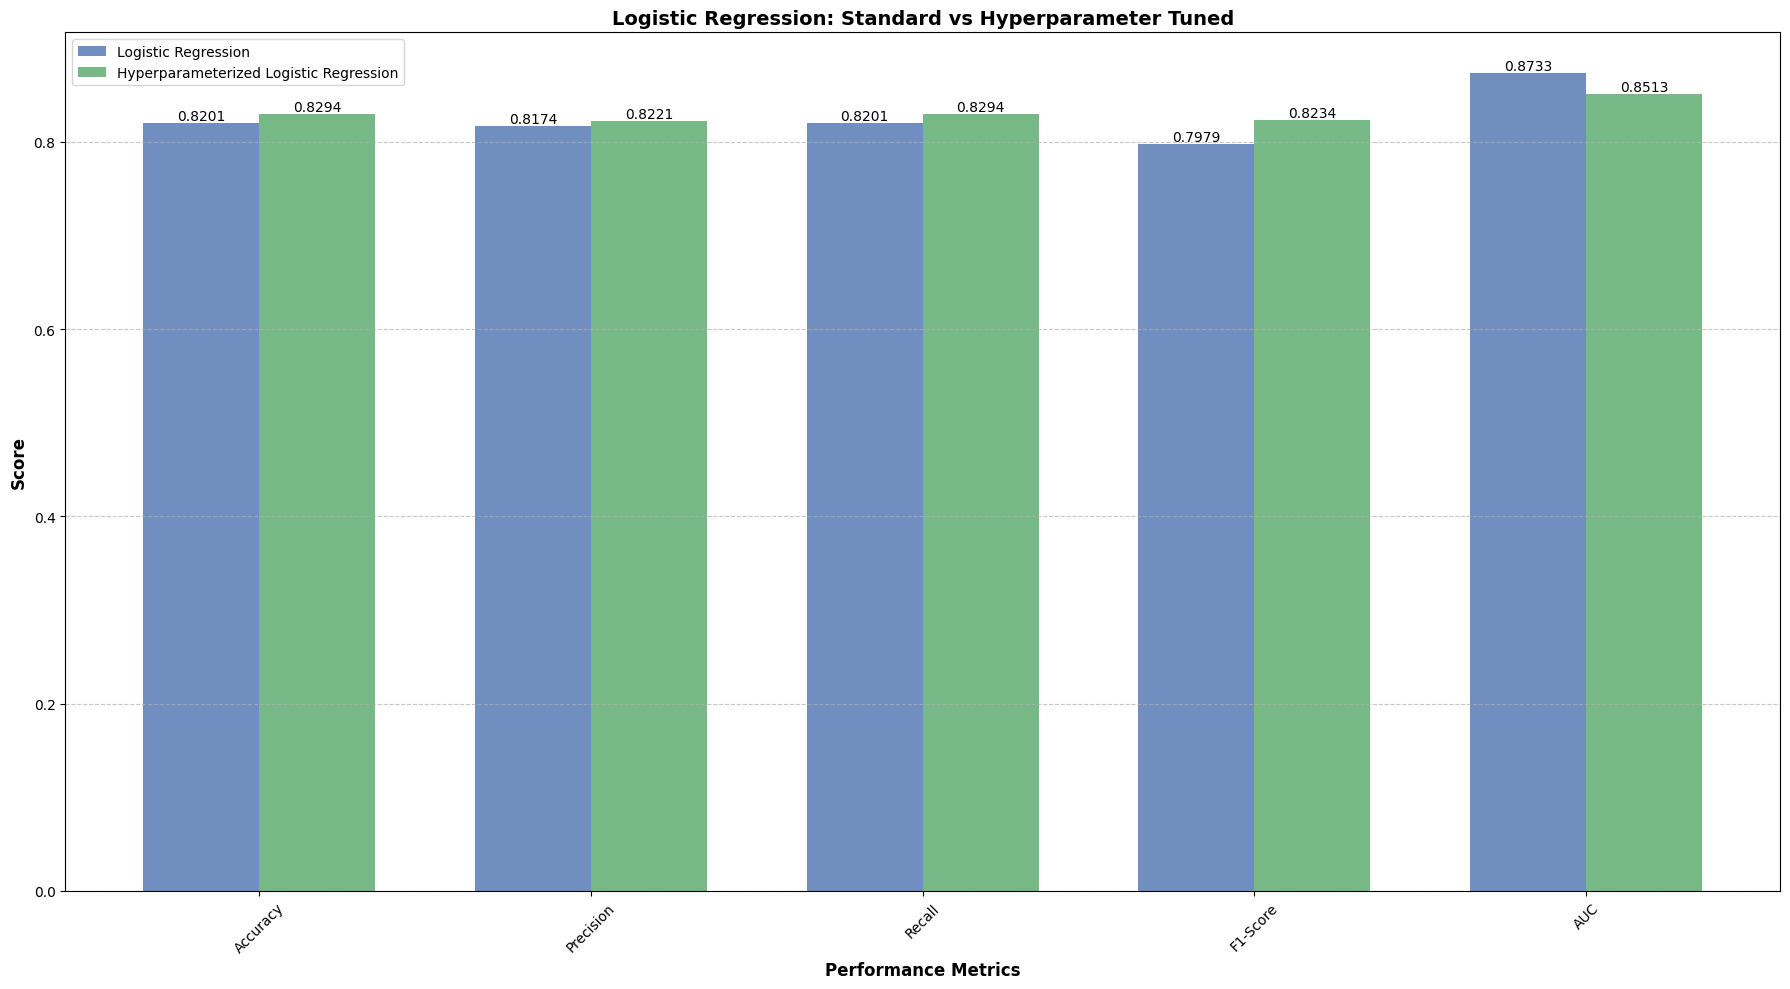

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Logistic Regression', 'Hyperparameterized Logistic Regression']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [

    [0.8201, 0.8174, 0.8201, 0.7979, 0.8733], # Logistic Regression
    [0.8294, 0.8221, 0.8294, 0.8234, 0.8513]   # Hyperparameterized Logistic Regression
]

# Set up the plot
plt.figure(figsize=(18, 10))

# Set the width of each bar and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Create bars
plt.bar(index, values[0], bar_width, label=models[0], color='#4C72B0', alpha=0.8)
plt.bar(index + bar_width, values[1], bar_width, label=models[1], color='#55A868', alpha=0.8)

# Customize the plot
plt.xlabel('Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Logistic Regression: Standard vs Hyperparameter Tuned', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width/2, metrics, rotation=45)
plt.legend()

# Add value labels on top of each bar
for i in range(len(metrics)):
    plt.text(i, values[0][i], f'{values[0][i]:.4f}', ha='center', va='bottom')
    plt.text(i + bar_width, values[1][i], f'{values[1][i]:.4f}', ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# prompt: Give the similar hyperparameter tuning code for Decision Tree

# Decision Tree with Hyperparameter Tuning
dt = DecisionTreeClassifier(labelCol="sentiment", featuresCol="features")

# Define parameter grid for Decision Tree
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

# Perform hyperparameter tuning and train
dt_model, dt_predictions, dt_accuracy, dt_precision, dt_recall, dt_f1_score = tune_and_train_with_metrics(
    dt, param_grid_dt, train_df, test_df, "Decision Tree"
)

# Evaluate AUC for Decision Tree
evaluator_auc_dt = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_dt = evaluator_auc_dt.evaluate(dt_predictions)
print(f"Decision Tree AUC: {auc_dt:.4f}")

Decision Tree:
  - Accuracy  = 0.7622
  - Precision = 0.7505
  - Recall    = 0.7622
  - F1-Score  = 0.6970

Decision Tree AUC: 0.4150


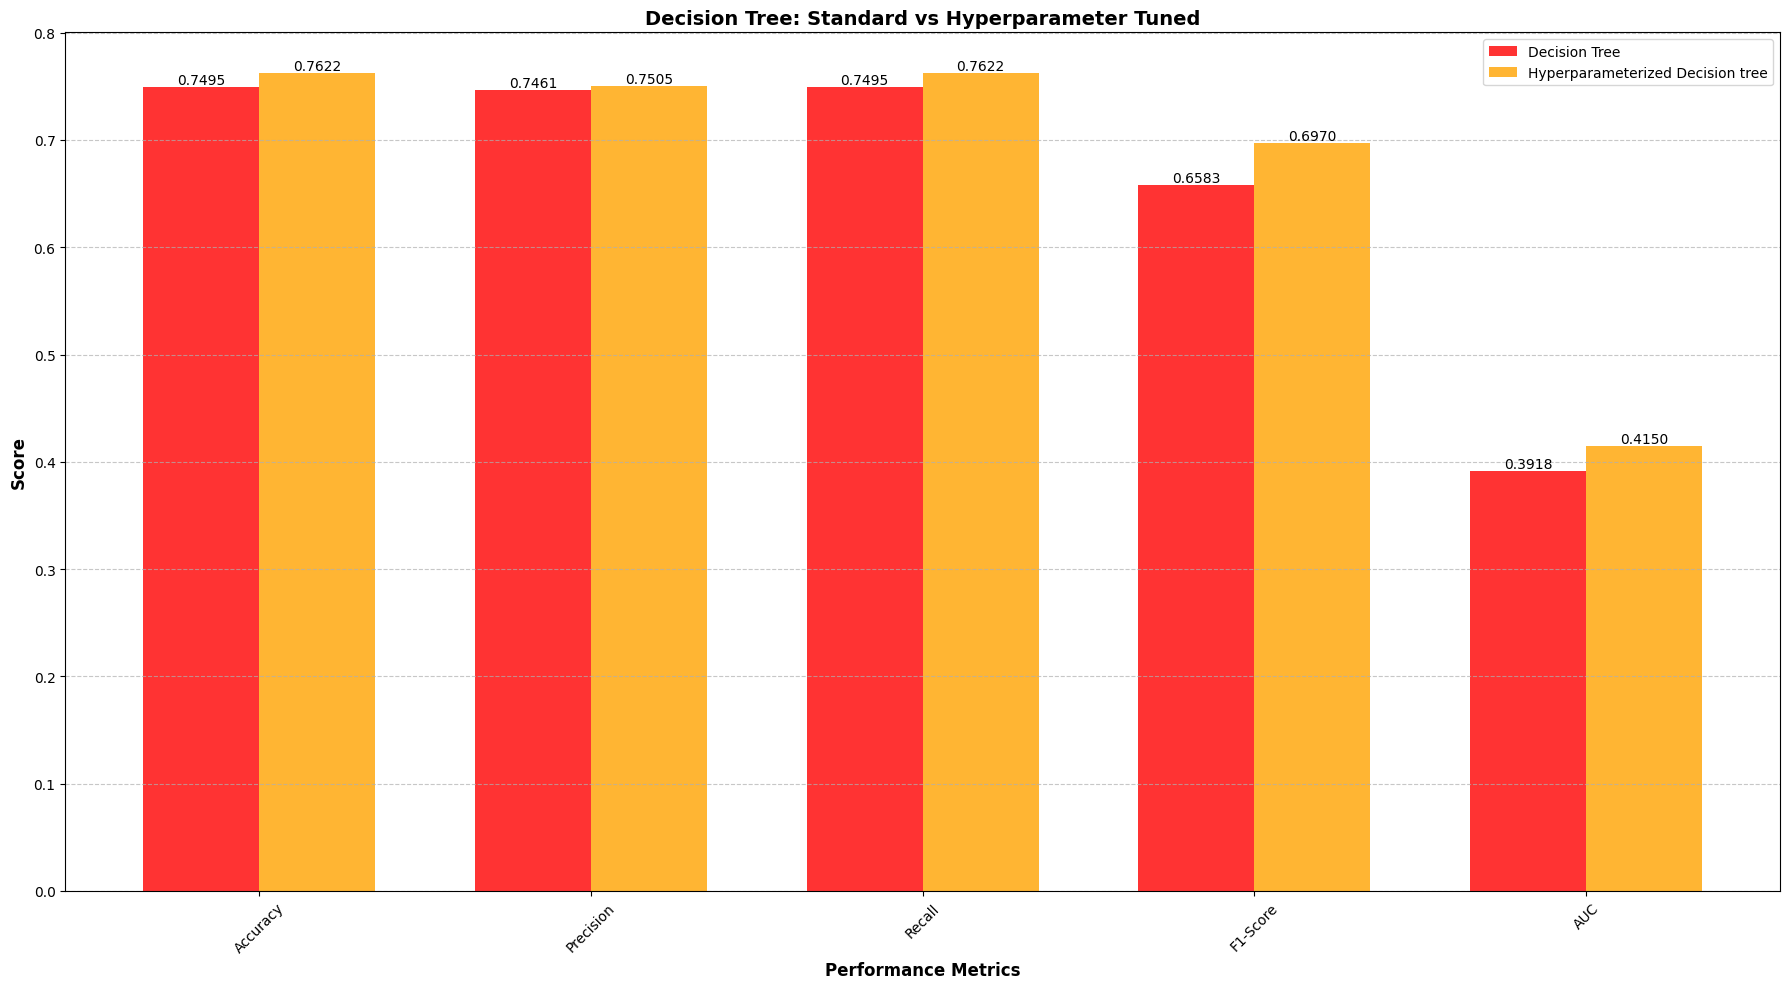

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Decision Tree', 'Hyperparameterized Decision tree']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [
    [0.7495, 0.7461, 0.7495, 0.6583, 0.3918],# Logistic Regression
    [0.7622, 0.7505, 0.7622, 0.6970, 0.4150]   # Hyperparameterized Logistic Regression
]

# Set up the plot
plt.figure(figsize=(18, 10))

# Set the width of each bar and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Create bars
plt.bar(index, values[0], bar_width, label=models[0], color='#FF0000', alpha=0.8)
plt.bar(index + bar_width, values[1], bar_width, label=models[1], color='#FFA300', alpha=0.8)

# Customize the plot
plt.xlabel('Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Decision Tree: Standard vs Hyperparameter Tuned', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width/2, metrics, rotation=45)
plt.legend()

# Add value labels on top of each bar
for i in range(len(metrics)):
    plt.text(i, values[0][i], f'{values[0][i]:.4f}', ha='center', va='bottom')
    plt.text(i + bar_width, values[1][i], f'{values[1][i]:.4f}', ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [50]:
# prompt: Give a similar code for Naive bayes with Hyperparameters

# Naive Bayes with Hyperparameter Tuning
nb = NaiveBayes(labelCol="sentiment", featuresCol="features")

# Define parameter grid for Naive Bayes
param_grid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Perform hyperparameter tuning and train
nb_model, nb_predictions, nb_accuracy, nb_precision, nb_recall, nb_f1_score = tune_and_train_with_metrics(
    nb, param_grid_nb, train_df, test_df, "Naive Bayes"
)

# Evaluate AUC for Naive Bayes
evaluator_auc_nb = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_nb = evaluator_auc_nb.evaluate(nb_predictions)
print(f"Naive Bayes AUC: {auc_nb:.4f}")


Naive Bayes:
  - Accuracy  = 0.8057
  - Precision = 0.8158
  - Recall    = 0.8057
  - F1-Score  = 0.8096

Naive Bayes AUC: 0.5393


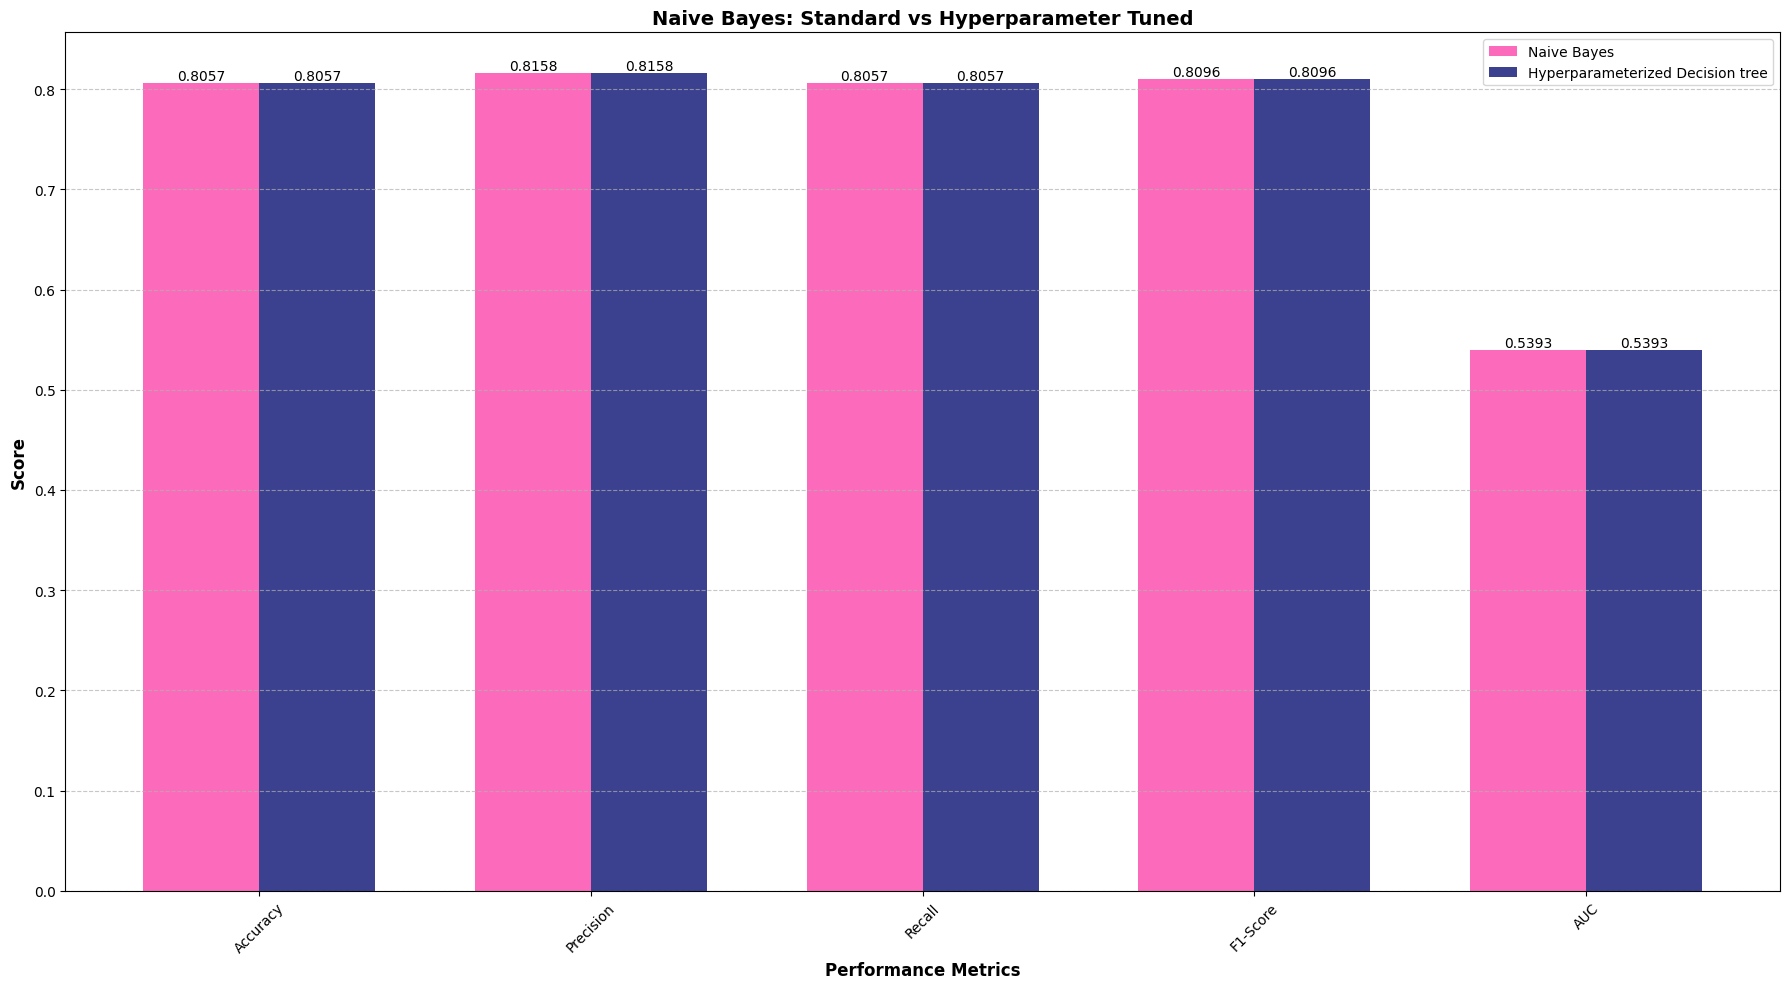

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Naive Bayes', 'Hyperparameterized Decision tree']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [
     [0.8057, 0.8158, 0.8057, 0.8096, 0.5393],
     [0.8057, 0.8158, 0.8057, 0.8096, 0.5393]
]

# Set up the plot
plt.figure(figsize=(18, 10))

# Set the width of each bar and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Create bars
plt.bar(index, values[0], bar_width, label=models[0], color='#FC46AA', alpha=0.8)
plt.bar(index + bar_width, values[1], bar_width, label=models[1], color='#0A1172', alpha=0.8)

# Customize the plot
plt.xlabel('Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Naive Bayes: Standard vs Hyperparameter Tuned', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width/2, metrics, rotation=45)
plt.legend()

# Add value labels on top of each bar
for i in range(len(metrics)):
    plt.text(i, values[0][i], f'{values[0][i]:.4f}', ha='center', va='bottom')
    plt.text(i + bar_width, values[1][i], f'{values[1][i]:.4f}', ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()